<a href="https://colab.research.google.com/github/anmol-pabla/VAE-Omniglot/blob/master/OMNIGLOT_VAE3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from keras import backend as K
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:

tfds.disable_progress_bar()
tf.enable_v2_behavior()
ds_train = tfds.load(
    'omniglot',
    split='train',
    shuffle_files=True,
    with_info=False,
)
def normalize_img(image, label):
  image = tf.image.resize(image, [28,28]) 
  return tf.cast(image, tf.float32) / 255., label
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.batch(19280)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


In [63]:
for example in ds_train.take(19280):
  image, label = example["image"], example["label"]
image,label = normalize_img(image,label)
image.shape
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# image_size = x_train.shape[1]
# original_dim = image_size * image_size
# x_train = x_train/ 255.0
# x_test = x_test / 255.0
# latent_size = 2

TensorShape([19280, 28, 28, 3])

In [0]:
    original_dim = 784
    latent_size = 2
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=K.shape(z_mean),
                                  mean=0., stddev=1)
        return z_mean + K.exp(z_log_sigma) * epsilon

In [64]:
    inputs = tf.keras.Input((28,28,3))
    x = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.Reshape((28,28,1))(x)
    x = tf.keras.layers.ZeroPadding2D(padding=2)(x)
    for n in [32,64,128,128,128]:
        x = tf.keras.layers.Conv2D(n, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    z_mean = tf.keras.layers.Dense(latent_size)(x)
    z_log_sigma = tf.keras.layers.Dense(latent_size)(x)
    # epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(z_mean), mean=0., stddev=1)
    # z = z_mean + tf.keras.backend.exp(z_log_sigma) * epsilon
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_size,))([z_mean, z_log_sigma])
    
    encoder = tf.keras.Model(inputs, z_mean,name='encoder')
    encoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 1)         28        
_________________________________________________________________
reshape_10 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0   

In [65]:
    decoder = tf.keras.Sequential(name='decoder')
    decoder.add(tf.keras.layers.InputLayer((latent_size,)))
    decoder.add(tf.keras.layers.Dense(128))
    decoder.add(tf.keras.layers.Reshape((1,1,128)))
    
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
      
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
    
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
        
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('relu'))
    
    decoder.add(tf.keras.layers.UpSampling2D(size=2))
    decoder.add(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same'))
    decoder.add(tf.keras.layers.Activation('sigmoid'))
    #decoder.add(tf.keras.layers.Flatten())
    #decoder.add(tf.keras.layers.Dense(1))

    decoder.add(tf.keras.layers.Cropping2D(cropping=2))
    decoder.add(tf.keras.layers.Reshape((28,28,3)))
    decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               384       
_________________________________________________________________
reshape_11 (Reshape)         (None, 1, 1, 128)         0         
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 2, 2, 128)         147584    
_________________________________________________________________
activation_31 (Activation)   (None, 2, 2, 128)         0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 128)         1475

In [66]:
    outputs = decoder(z)
    vae = tf.keras.Model(inputs, outputs,name='vae')
    vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 28, 28, 1)    28          input_7[0][0]                    
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 28, 28, 1)    0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 32, 32, 1)    0           reshape_10[0][0]                 
________________________________________________________________________________________________

In [0]:
                                                                     
def vae_loss(y_true, y_pred):
        recon_loss = tf.keras.backend.sum(tf.keras.backend.square(y_true-y_pred), axis=[1,2])
        kl_loss = - 0.5 * tf.keras.backend.sum(1 + 2*z_log_sigma - tf.keras.backend.square(z_mean) - tf.keras.backend.square(tf.keras.backend.exp(z_log_sigma)), axis=-1)
        return recon_loss + kl_loss

In [81]:
vae.compile(optimizer='adamax', loss='BinaryCrossentropy', metrics=['accuracy'])
epochs=50
vae.fit(image,image,
        epochs=epochs)

Epoch 1/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1813 - accuracy: 0.4158
Epoch 2/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1803 - accuracy: 0.4092
Epoch 3/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1799 - accuracy: 0.4059
Epoch 4/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1796 - accuracy: 0.4044
Epoch 5/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1793 - accuracy: 0.4043
Epoch 6/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1791 - accuracy: 0.4041
Epoch 7/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1789 - accuracy: 0.4029
Epoch 8/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1787 - accuracy: 0.4025
Epoch 9/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1786 - accuracy: 0.4060
Epoch 10/50
603/603 [==============================] - 4s 6ms/step - loss: 0.1785 - accuracy: 0.4035



ORIGINAL-->



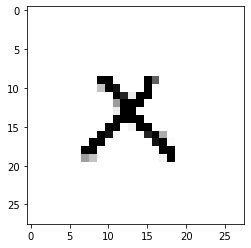


GENERATED-->



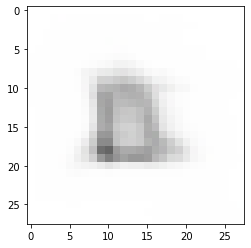



ORIGINAL-->



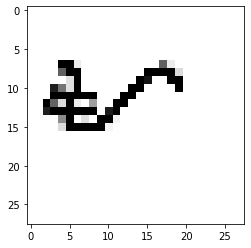


GENERATED-->



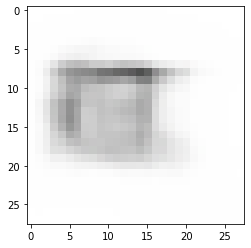



ORIGINAL-->



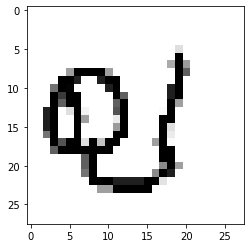


GENERATED-->



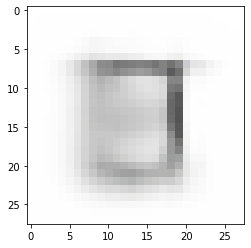



ORIGINAL-->



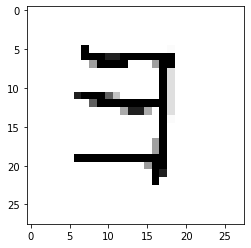


GENERATED-->



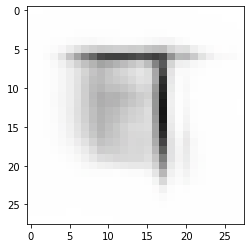



ORIGINAL-->



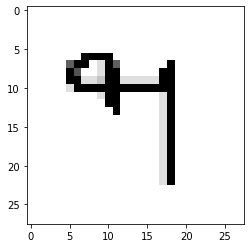


GENERATED-->



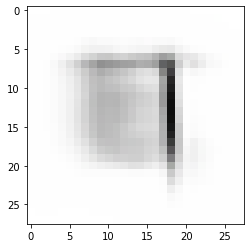

In [90]:
import numpy as np
import random
t=0
while t<5:

  i = random.choice(np.arange(19280))
  print("\n\nORIGINAL-->\n")
  plt.imshow(image[i])
  plt.show()
  print("\nGENERATED-->\n")
  pred = (vae.predict(image)[i])
  plt.imshow(pred.reshape((28,28,3)))
  plt.show()
  t+=1 